In [1]:
%matplotlib inline
from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl


In [2]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots(df,pol,ylabel,xlabel,suffixes,legend, size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_obs','_mod']
    legend   : list of two strings
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[['station','type',pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique())
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':0.4}, 
                           subplot_kw={'ylabel':ylabel,'xlabel':xlabel})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='k', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='g', marker='o',markersize=markersize,markeredgecolor='none',linestyle='none',lw=lw, alpha=alpha, label=legend[1])
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%a-%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n\n\n%b-%y'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[i].set_xlabel(xlabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=7)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight', facecolor='w')



# Evaluation of Simulation Results for September 2018
Two types of measured data are air quality and meteorological parameters from CETESB stations. Only IAG station belongs to São Paulo University, located in Água Funda, and measures meteorological parameters. The evaluation period corresponds to September 1-30, 2018. Measured data has time series in hourly resolution.

Some stations located close to coastal zone were not included as part of statistical evaluation, which are:

* Santos
* Santos-Ponta da Praia
* Cubatão-Centro
* Cubatão-Vale do Mogi
* Cubatão-V.Parisi

Furthermore, hourly measurements for September 14-15, 2018 were not considered to statistical analysis due to cloud and rainfall conditions that WRF-Chem couldn't simulate adequately. Following Figure shows mean cloud cover and total rain by day, gray highlight represents days excluded in the statistical evaluation.

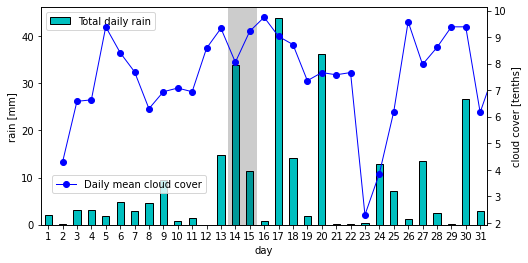

In [3]:
met_iag = pd.read_csv('../2_Met/IAG/all_met_0.csv', parse_dates=True, index_col='local_date')
met_iag['day'] = met_iag.index.day
met_iag = met_iag[['day','rr','cc']].groupby('day').agg({'rr':'sum','cc':'mean'})
fig, ax = plt.subplots(figsize=(8,4))
plot_rr = met_iag.rr.plot(kind='bar', rot=0, color='c', edgecolor='k', label='Total daily rain', legend=True)
ax.legend(loc=2)
ax2 = ax.twinx()
met_iag.cc.plot(rot=0,ax=ax2, lw=1, color='b',marker='o',label='Daily mean cloud cover', legend=True)
ax2.legend(bbox_to_anchor=(0.38, 0.25))
ax.set_ylabel('rain [mm]')
ax2.set_ylabel('cloud cover [tenths]')
def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='0', edgecolor='none', alpha=.2)
        i+=1
highlight([13,14], plot_rr)
fig.savefig('../4_Draft_Report/Dissertation/fig/rain_cc.pdf', bbox_inches='tight')

In [4]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations.head()

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb


In [5]:
 print(f"""
 We have {stations.name.nunique()} stations with hourly measurements obtained to compared with
 WRF-Chem results. Also, there are {stations.type.nunique()} stations type, which are:
 {list(stations.type.unique())}.
 """)


We have 57 stations with hourly measurements obtained to compared with
WRF-Chem results. Also, there are 5 stations type, which are:
['Forest preservation', 'Urban', 'Regional urban', 'Urban park', 'Industry'].



## September, 2018

WRF-Chem model results for September 2018 correspond to second domain with spatial resolution of 3 km $\times$ 3 km. The results were obtained using NALROM as chemical boundary conditions and NCEP Final Analysis from GFS as meteorology initial and boundary conditions. To model all hours of September, model was reinitializated each 5 days with one day of spin-up was done, methodology suggested by Ritter (2013). We use the function `readDat` to import and merge WRF-Chem data by station name, named as `data`. O$_3$ 8 hours rolling mean was calculated and named as `rollo3`. Hourly mean by station type was also calculated and named as `by_type`.

In [6]:
# Import and join Obs and Mod data
#filename = 'alldata_Sep18_not14_15.pkl' # as pandas DataFrame
fname_1 = 'Obs_dic_not14_15.pickle'     # as Dictionary
fname_2 = 'Mod_dic_not14_15.pickle'     # as Dictionary
filename = 'alldata_Sep18.pkl'
#fname_1 = 'Obs_dic.pickle'
#fname_2 = 'Mod_dic.pickle'

if os.path.exists(filename) is False:
    # Meteorological parameters observations
    Dir = '../1_ObsData/SEP18/'
    f18 = fnmatch.filter(os.listdir(Dir), 'all_met*.csv')
    metObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo',from_wrf = False)

    # Air quality parameters observations
    f18 = fnmatch.filter(os.listdir(Dir), 'all_photo*.csv')
    aqObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo', from_wrf = False)
    Obs = pd.merge(metObs, aqObs)
    Obs['nox']=Obs.no+Obs.no2
    #start_remove = pd.to_datetime('2018-09-14').tz_localize('America/Sao_Paulo')
    #end_remove = pd.to_datetime('2018-09-16').tz_localize('America/Sao_Paulo')
    #Obs = Obs.loc[(Obs.local_date < start_remove) | (Obs.local_date > end_remove)]
    # As dictionary
    Obs_dic = {}
    for code in stations.code:
        Obs_dic[stations.name[stations.code == code].values[0]] = (Obs[Obs.code==code])

    # WRF-Chem output re-initialization with one day of spin-up
    Dir = '../3_Results/Y2018/wrfout_exp10/sep18/'
    f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

    Mod = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    Mod.rename(columns={'name':'station'})
    Mod = Mod[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    Mod['nox'] = Mod.no+Mod.no2
      # As dictionary
    Mod_dic = {}
    for code in stations.code:
        Mod_dic[stations.name[stations.code == code].values[0]] = (Mod[Mod.code==code])

    data = pd.merge(Obs, Mod,
                    on=['local_date','station','code','type'],
                    suffixes=('_obs', '_mod'))
    # to pickle
    data.to_pickle(filename)
    pkl.dump(Obs_dic, open(fname_1, "wb"))
    pkl.dump(Mod_dic, open(fname_2, "wb"))

else:
    data = pd.read_pickle(filename)
    Obs_dic = pkl.load(open(fname_1, "rb"))
    Mod_dic = pkl.load(open(fname_2, "rb"))

# Rolling 8 hour mean
o3 = data[['local_date','station','type', 'o3_obs','o3_mod']].set_index('local_date')
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3_obs','o3_mod']])
    roll_o3[i]['station'] = (i)
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()

# Hourly mean by station type
by_type = data.groupby(['local_date','type']).mean().reset_index().drop(['code'], axis=1)

### Statistical Evaluation
The `Mod_statistic` script was built by Mario Gavidia and with few changes done by me. Here you see the follow functions:
```python
* aq_Stats(data, polls=['o3', 'no', 'no2', 'co', 'tc', 'rh'])
* met_stats(data,mets=['tc','rh','ws','wd'])
* r_pearson_sig(n, r, alpha, deg_free = 2)
* r_pearson_confidence_interval(n, r, alpha)
```

Statistical benchmarks from Emery et al. (2017) were used to evaluate surface ozone (1 hour or mean values of the daily maximum 8 h average (MDA8) ozone) obtained from the WRF-Chem model:

Parameter |   Goal   |  Criteria  |
--------- |----------|----------- |
NMB | < $\pm$5% | < $\pm$15%
NME | < 15% | < 25%
r | > 0.75 | > 0.5

Furthermore, statistical benchmarks from Monk et al. (2019) were used to evaluate meteorology results for complex terrain:

Parameter        | Criteria (complex terrain)
----------       | --------
Temperature      | MB  $\leq\pm$ 1 K
                 | MAGE $\leq$ 3.0
                 | IOA $\geq$ 0.8
Wind speed       | RMSE $\leq$ 2.5
                 | MB   $\leq \pm$ 1.5 ms$^{-1}$
                 | IOA $\geq$ 0.6
Wind direction   | MB < $\pm$ 10º
                 | ME $\leq$ 55º
Relative Humidity| MB < $\pm$10%
                 | MAGE < 20%
                 | IOA $\geq$ 0.6

Global statistical results by hour are showed in the following table.

In [22]:
import mod_stats as ms
gl_stat = ms.aq_stats(data,
             polls=['o3', 'no', 'no2', 'nox','co']).round(2)
gl_stat.T.to_pickle('gl_stat_sep18.pkl')
gl_stat.T

,o3,no,no2,nox,co
n,25754.00,23374.00,23374.00,23374.00,10649.00
MB,10.71,-1.34,3.24,1.90,-0.27
MAGE,24.91,10.87,18.62,28.44,0.31
RMSE,31.17,24.46,26.02,44.59,0.42
NMB,22.80,-15.06,12.21,5.36,-54.25
NME,53.07,121.90,70.10,80.15,60.85
IOA,0.78,0.44,0.61,0.56,0.44
r,0.64,0.22,0.37,0.31,0.15
Mm,57.65,7.58,29.81,37.38,0.23
Om,46.94,8.92,26.56,35.48,0.50


In [29]:
by = 'type'
sites = list(data[[by,'o3_obs','o3_mod']].dropna().sort_values(by=by,ascending=True)[by].unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data[by].isin([i])],polls=['o3']))
    o3_stats[i][by] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_df = o3sta_df.set_index('type').T.rename(columns={'Industry':'Ind',
                                                        'Forest preservation':'F. pre.',
                                                        'Regional urban':'R. urb.',
                                                        'Urban park': 'U. park',
                                                        'Urban':'Urb'})
o3sta_df = o3sta_df[['F. pre.','Urb','U. park','Ind','R. urb.']]
o3sta_df.to_pickle('o3sta_sep18.pkl')
o3sta_df

type,F. pre.,Urb,U. park,Ind,R. urb.
n,686.00,12225.00,2355.00,686.00,9802.00
MB,1.36,5.47,-0.23,18.56,19.97
MAGE,24.52,24.10,24.13,28.43,25.90
RMSE,30.53,30.51,30.16,34.07,32.05
NMB,2.76,12.57,-0.50,38.20,39.12
NME,49.79,55.43,51.72,58.52,50.72
IOA,0.80,0.78,0.80,0.83,0.74
r,0.70,0.65,0.66,0.78,0.67
Mm,50.61,48.94,46.41,67.15,71.04
Om,49.25,43.48,46.65,48.59,51.06


In [12]:
sites = list(data[['station','o3_obs','o3_mod']].dropna().sort_values(by='station',ascending=True).station.unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data.station.isin([i])],polls=['o3']))
    o3_stats[i]['station'] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_df['abb'] = [stations[stations.name == i].abb.values[0] for i in o3sta_df.station]
o3sta_df['type'] = [stations[stations.name == i].type.values[0] for i in o3sta_df.station]
o3sta_df[(o3sta_df.n > 600) & (o3sta_df.NME < 60) & (o3sta_df.NMB < 40)]

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,station,abb,type
o3,637,17.20,27.23,32.52,33.95,53.75,0.85,0.80,67.85,50.65,36.60,46.19,Paulínia,Pln,Industry
o3,637,9.70,19.25,24.26,15.62,30.99,0.86,0.78,71.82,62.11,29.96,35.50,Campinas-Taquaral,CpT,Regional urban
o3,636,18.61,25.75,30.34,34.08,47.16,0.82,0.78,73.22,54.61,30.92,38.49,Piracicaba,Prcb,Regional urban
o3,609,14.76,24.39,29.72,24.09,39.81,0.82,0.76,76.03,61.27,30.95,39.59,Americana,Ame,Regional urban
o3,640,14.79,24.06,29.89,29.03,47.22,0.84,0.76,65.73,50.94,37.66,37.91,Jundiaí,Jnd,Regional urban
o3,640,2.48,25.14,30.67,5.21,52.84,0.84,0.74,50.06,47.58,45.61,35.43,Carapicuíba,Crp,Urban
o3,649,2.15,23.10,29.42,5.07,54.63,0.84,0.73,44.43,42.28,43.21,32.58,Santana,Stna,Urban
o3,640,19.53,23.23,27.47,36.29,43.16,0.74,0.72,73.34,53.81,21.73,27.67,Jaú,Jau,Regional urban
o3,636,0.51,24.44,30.64,1.02,48.90,0.81,0.72,50.49,49.98,43.91,28.98,Pico do Jaraguá,PdJr,Forest preservation
o3,640,-8.55,24.18,30.26,-16.63,47.04,0.82,0.72,42.86,51.40,41.82,33.11,Ibirapuera,Ibir,Urban park


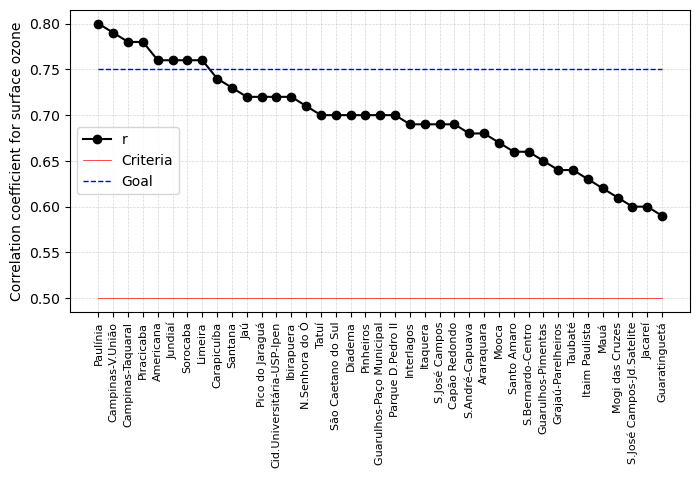

In [13]:
x = o3sta_df.station

fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(x,o3sta_df.r,'ko-', label='r')
plt.plot(x,[0.5 for i in x],'r-', label='Criteria', lw=0.5)
plt.plot(x,[0.75 for i in x],'b--', label='Goal', lw=1)
plt.xticks(x, rotation='vertical', fontsize=8)
plt.ylabel('Correlation coefficient for surface ozone')
plt.legend()
plt.grid(color='0.2', ls='--', lw=0.5,alpha=0.2)
fig.savefig('../4_Draft_Report/Dissertation/fig/o3_r_by_station.pdf',bbox_inches='tight')

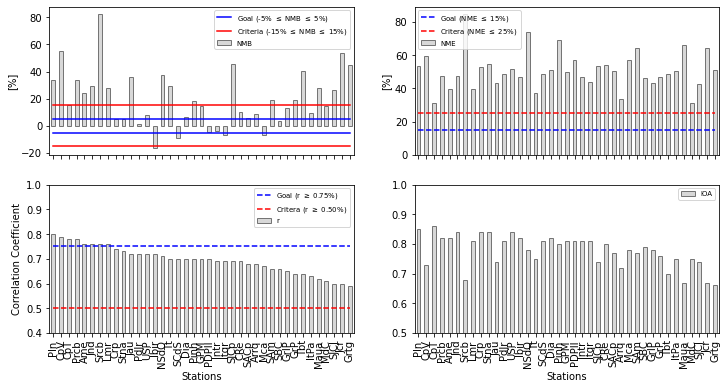

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12,6),sharex=True)
df_stat = o3sta_df

# Script
NMB = df_stat.reset_index(drop=True).set_index('abb')[['NMB']]
NMB['PG'] = 5
NMB['NG'] = -5
NMB['PC'] = 15
NMB['NC'] = -15
# ax[0,0]
NMB.NMB.plot.bar(rot=90,ax=ax[0,0], color='0.7',edgecolor='k', alpha=0.5, label = 'NMB')
NMB['PG'].plot(rot=90,ax=ax[0,0], color='b',label = 'Goal (-5% $\leq$ NMB $\leq$ 5%)')
NMB['NG'].plot(rot=90,ax=ax[0,0], color='b',label = '')
NMB['PC'].plot(rot=90,ax=ax[0,0], color='r',label = 'Criteria (-15% $\leq$ NMB $\leq$ 15%)')
NMB['NC'].plot(rot=90,ax=ax[0,0], color='r',label = '')
ax[0,0].legend(fontsize=7)
ax[0,0].set_ylabel('[%]')

# ax[0,1]
NME = df_stat.reset_index(drop=True).set_index('abb')[['NME']]
NME['G'] = 15
NME['C'] = 25
NME.NME.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[0,1], label='NME')
NME['G'].plot(rot=90,ax=ax[0,1], color='b',linestyle='--', label='Goal (NME $\leq$ 15%)')
NME['C'].plot(rot=90,ax=ax[0,1], color='r',linestyle='--', label='Critera (NME $\leq$ 25%)')
ax[0,1].legend(fontsize=7)
ax[0,1].set_ylabel('[%]')

# ax[1,0]
r = df_stat.reset_index(drop=True).set_index('abb')[['r']]
r['G'] = 0.75
r['C'] = 0.50
r.r.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,0])
r['G'].plot(rot=90,ax=ax[1,0], color='b',linestyle='--', label='Goal (r $\geq$ 0.75%)')
r['C'].plot(rot=90,ax=ax[1,0], color='r',linestyle='--', label='Critera (r $\geq$ 0.50%)')
ax[1,0].set_ylabel('Correlation Coefficient')
ax[1,0].set_ylim([0.4,1])
ax[1,0].set_xlabel('Stations')
ax[1,0].legend(fontsize=7)

# ax[1,1]
IOA = df_stat.reset_index(drop=True).set_index('abb')[['IOA']]
IOA.IOA.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,1], label='IOA')
ax[1,1].legend(fontsize=7)
ax[1,1].set_ylim([0.5,1])
ax[1,1].set_xlabel('Stations')

fig.savefig('../4_Draft_Report/Dissertation/fig/o3_stats.pdf',bbox_inches='tight', facecolor='w')

And by station type for MDA8 for surface ozone:

In [16]:
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())
o3_stats_type = {}
o3sta_df = pd.DataFrame()
for i in types:
    o3_stats_type[i] = (ms.aq_stats(MDA8[MDA8.type.isin([i])],polls=['o3']))
    o3_stats_type[i]['type'] = (i)
    df = o3_stats_type[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,type
o3,28,24.33,27.66,32.24,32.65,37.12,0.65,0.65,98.83,74.51,27.66,23.09,Forest preservation
o3,28,6.54,21.11,27.29,6.72,21.69,0.80,0.72,103.85,97.32,25.72,38.70,Industry
o3,402,14.83,21.24,26.44,17.77,25.45,0.68,0.56,98.30,83.47,20.94,25.21,Regional urban
o3,493,22.07,23.19,28.16,31.74,33.34,0.71,0.73,91.62,69.55,24.30,22.93,Urban
o3,101,14.92,18.34,22.54,19.80,24.34,0.76,0.73,90.29,75.37,22.58,23.19,Urban park


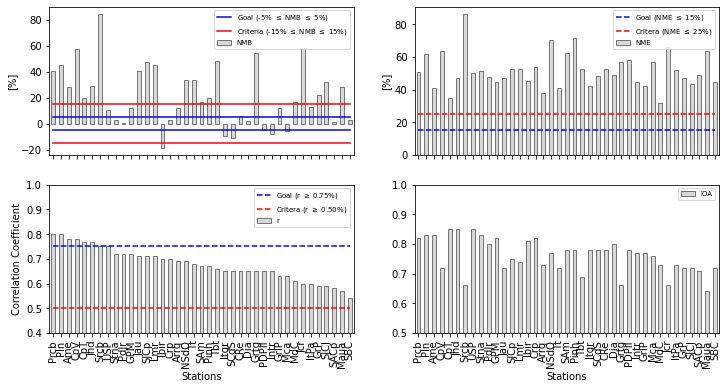

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,6),sharex=True)
df_stat = o3sta_df

# Script
NMB = df_stat.reset_index(drop=True).set_index('abb')[['NMB']]
NMB['PG'] = 5
NMB['NG'] = -5
NMB['PC'] = 15
NMB['NC'] = -15
# ax[0,0]
NMB.NMB.plot.bar(rot=90,ax=ax[0,0], color='0.7',edgecolor='k', alpha=0.5, label = 'NMB')
NMB['PG'].plot(rot=90,ax=ax[0,0], color='b',label = 'Goal (-5% $\leq$ NMB $\leq$ 5%)')
NMB['NG'].plot(rot=90,ax=ax[0,0], color='b',label = '')
NMB['PC'].plot(rot=90,ax=ax[0,0], color='r',label = 'Criteria (-15% $\leq$ NMB $\leq$ 15%)')
NMB['NC'].plot(rot=90,ax=ax[0,0], color='r',label = '')
ax[0,0].legend(fontsize=7)
ax[0,0].set_ylabel('[%]')

# ax[0,1]
NME = df_stat.reset_index(drop=True).set_index('abb')[['NME']]
NME['G'] = 15
NME['C'] = 25
NME.NME.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[0,1], label='NME')
NME['G'].plot(rot=90,ax=ax[0,1], color='b',linestyle='--', label='Goal (NME $\leq$ 15%)')
NME['C'].plot(rot=90,ax=ax[0,1], color='r',linestyle='--', label='Critera (NME $\leq$ 25%)')
ax[0,1].legend(fontsize=7)
ax[0,1].set_ylabel('[%]')

# ax[1,0]
r = df_stat.reset_index(drop=True).set_index('abb')[['r']]
r['G'] = 0.75
r['C'] = 0.50
r.r.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,0])
r['G'].plot(rot=90,ax=ax[1,0], color='b',linestyle='--', label='Goal (r $\geq$ 0.75%)')
r['C'].plot(rot=90,ax=ax[1,0], color='r',linestyle='--', label='Critera (r $\geq$ 0.50%)')
ax[1,0].set_ylabel('Correlation Coefficient')
ax[1,0].set_ylim([0.4,1])
ax[1,0].set_xlabel('Stations')
ax[1,0].legend(fontsize=7)

# ax[1,1]
IOA = df_stat.reset_index(drop=True).set_index('abb')[['IOA']]
IOA.IOA.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,1], label='IOA')
ax[1,1].legend(fontsize=7)
ax[1,1].set_ylim([0.5,1])
ax[1,1].set_xlabel('Stations')

fig.savefig('../4_Draft_Report/Dissertation/fig/o3_stats.pdf',bbox_inches='tight')

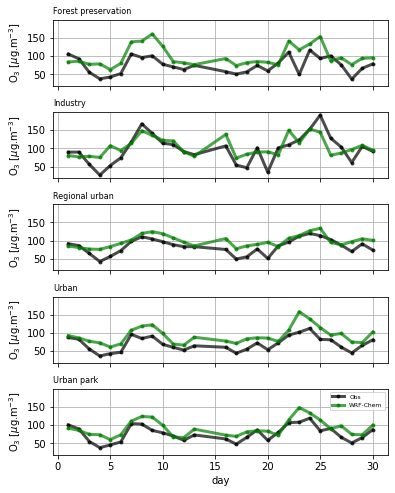

In [18]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       subplot_kw={'ylabel':'O$_3$ [$\mu$g.m$^{-3}$]'},
                       gridspec_kw={'hspace':0.4})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=10,
          color='kg', lw=3, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    if i == len(types)-1:
        ax[i].legend(['Obs','WRF-Chem'],fontsize=6)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_type.pdf',bbox_inches='tight', facecolor='w')

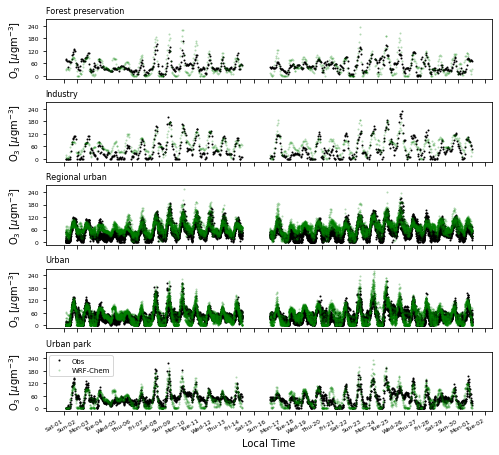

In [31]:
subplots(data.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_type',
         alpha=.3,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')

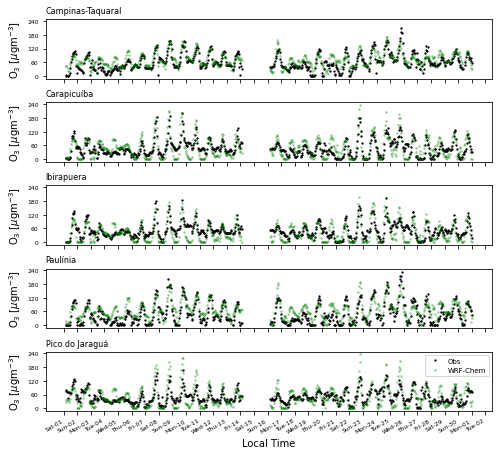

In [32]:
st_names = ['Pico do Jaraguá','Paulínia','Campinas-Taquaral','Carapicuíba','Ibirapuera']
df_plot = data[data.station.isin(st_names)]

subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.4,
         markersize=2.5,
         lw=2,
         labelsize=6, 
         by='station')

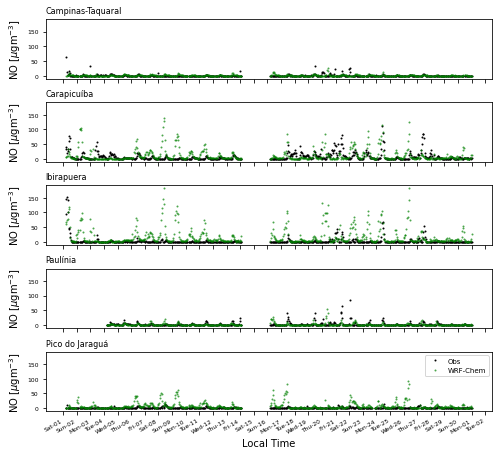

In [44]:
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='no',
         ylabel='NO [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

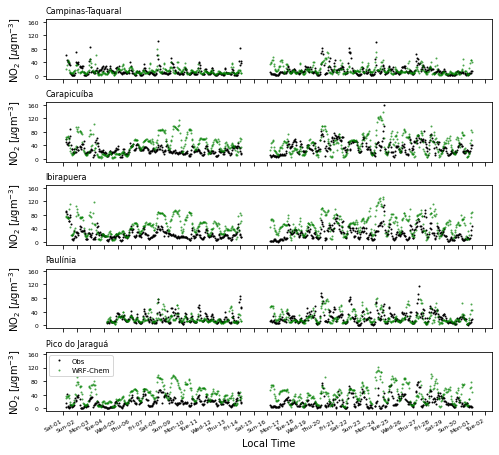

In [45]:
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='no2',
         ylabel='NO$_2$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

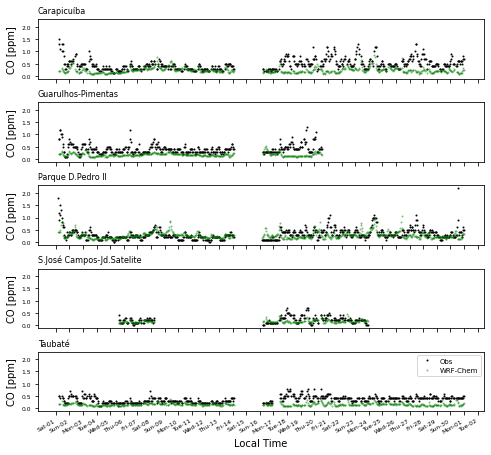

In [43]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.5,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

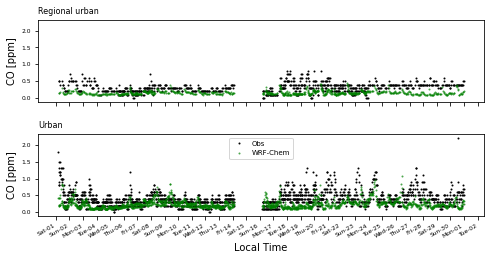

In [42]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,4),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')